In [1]:
import numpy as np
import os
import scipy
from sklearn.metrics import classification_report,confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt

/home/qbw/anaconda3/envs/qbw_base/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
feature_path = '/public/DATA/qbw/dataset/zero_shot/awa2/Animals_with_Attributes2/Features/ResNet101'

feature = np.loadtxt(os.path.join(feature_path,'AwA2-features.txt'),dtype=np.float32)

feature.shape

(37322, 2048)

In [3]:
parent_path = '/public/DATA/qbw/dataset/zero_shot/awa2/Animals_with_Attributes2'
train_classes,test_classes = [],[]
with open(os.path.join(parent_path,'trainclasses.txt'),'r') as f:
    for line in f:
        line = line.strip()
        train_classes.append(line)

with open(os.path.join(parent_path,'testclasses.txt'),'r') as f:
    for line in f:
        line = line.strip()
        test_classes.append(line)

In [4]:
id2cls,cls2id = {},{}
classes = []
with open(os.path.join(parent_path,'classes.txt'),'r') as f:
    for line in f:
        id,cls = line.strip().split('\t')
        id = int(id)
        cls2id[cls] = id
        id2cls[id] = cls
        classes.append(cls)

In [5]:
labels = np.loadtxt(os.path.join(feature_path,'AwA2-labels.txt'),dtype=int)
binary_predicates = np.loadtxt(os.path.join(parent_path,'predicate-matrix-binary.txt'),dtype=int)

train_feat,test_feat = [],[]
train_predicate,test_predicate = [],[]
train_gt,test_gt = [],[]
for i,feat in enumerate(feature):
    if id2cls[labels[i]] in train_classes:
        train_feat.append(feat)
        train_predicate.append(binary_predicates[labels[i]-1])
        train_gt.append(labels[i])
    else:
        test_feat.append(feat)
        test_predicate.append(binary_predicates[labels[i]-1])
        test_gt.append(labels[i])
train_feat = np.array(train_feat)
test_feat = np.array(test_feat)
train_predicate = np.array(train_predicate)
test_predicate = np.array(test_predicate)

train_feat.shape,train_predicate.shape,len(test_gt)


((30337, 2048), (30337, 85), 6985)

In [6]:
class AwA2_Dataset(Dataset):
    def __init__(self,feat,predicate,gt):
        super(AwA2_Dataset,self).__init__()
        self.feat = feat
        self.predicate = predicate
        self.gt = gt
    
    def __len__(self):
        return self.feat.shape[0]
    
    def __getitem__(self,index):
        feat = self.feat[index]
        predicate = self.predicate[index]
        gt = self.gt[index]
        return torch.from_numpy(feat),torch.from_numpy(predicate),torch.tensor(gt,dtype=int)

class linear(nn.Module):
    def __init__(self,feat_dim,predicate_dim):
        super(linear,self).__init__()
        self.W = nn.Linear(feat_dim,predicate_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,feat):
        return self.sigmoid(self.W(feat))

In [7]:
trainset = AwA2_Dataset(train_feat,train_predicate,train_gt)
testset = AwA2_Dataset(test_feat,test_predicate,test_gt)

def train(epochs,bs,lr,device,feat_dim,predicate_dim):
    train_loader = DataLoader(trainset,batch_size=bs,shuffle=True,num_workers=16)
    # test_loader = DataLoader(testset,shuffle=False,num_workers=16)

    model = linear(feat_dim,predicate_dim).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam([{'params':[param for name,param in model.named_parameters() 
        if 'bias' in name],'weight_decay':0.},{'params':[param for name,param in model.named_parameters() 
        if 'weight' in name]}],lr=lr)
    model.train()
    tloss = []
    for epoch in tqdm(range(epochs)):
        train_loss = 0.
        for feat,predicate,_ in train_loader:
            feat,predicate = feat.to(device),predicate.to(device)
            predicate = predicate.float()
            pred_seg = model(feat)
            loss = criterion(pred_seg,predicate)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        tloss.append(train_loss/len(train_loader))
    
    plt.figure()
    plt.plot(tloss)
    
    return model

    
    

100%|██████████| 100/100 [02:30<00:00,  1.51s/it]


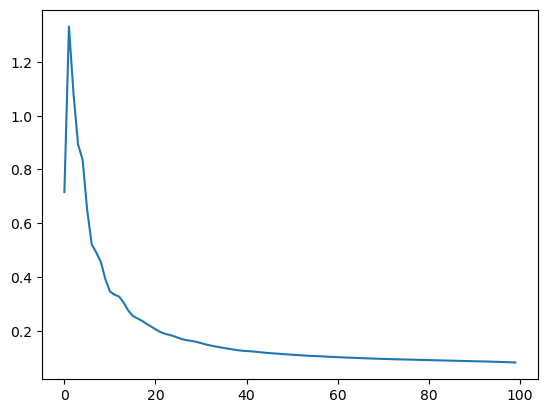

In [8]:
train_hyper_param = {'epochs':100,'bs':len(trainset),'lr':1e-2,'device':
    torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
    'feat_dim':train_feat.shape[1],'predicate_dim':train_predicate.shape[1]}

model = train(**train_hyper_param)

In [14]:
def get_euclidean_dist(curr_labels, class_labels):
  return np.sqrt(np.sum((curr_labels - class_labels)**2))

def predicates_to_class(pred,binary_predicates,classes,train_classes):
    predictions = []
    for i in range(pred.shape[0]):
        curr_labels = pred[i,:].cpu().detach().numpy()
        best_dist = sys.maxsize
        best_index = -1
        for j in range(binary_predicates.shape[0]):
            class_labels = binary_predicates[j,:]
            dist = get_euclidean_dist(curr_labels, class_labels)
            if dist < best_dist and classes[j] not in train_classes:
                best_index = j
                best_dist = dist
        predictions.append(classes[best_index])
    return predictions

def test(model,testset,binary_predicates,classes,cls2id,train_classes):
    test_loader = DataLoader(testset,batch_size=1,shuffle=False,num_workers=16)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    test_pred = []
    gts = []
    model.eval()
    with torch.no_grad():
        for feat,_,gt in test_loader:
            feat = feat.to(device)
            pred = model(feat)
            pred = predicates_to_class(pred,binary_predicates,classes,train_classes)
            test_pred.extend(pred)
            gts.extend(gt.tolist())
    # print(test_pred)
    # assert False,print(len(gts),len(test_pred))
    acc = 0.
    for i in range(len(test_pred)):
        # if i < 100:
            # print(cls2id[test_pred[i]],test_gt[i],end=' ')
        # print('\n')
        if cls2id[test_pred[i]] == gts[i]:
            acc += 1
    return (acc / len(test_gt)) * 100

print(test(model,testset,binary_predicates,classes,cls2id,train_classes))
            


60.60128847530423
